# **Rakuten Advertising Case Interview**

# **Import necessary libraries**

In [ ]:
# !pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as py
import statsmodels.api as sm

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import kurtosis, skew
from sklearn.metrics import mean_squared_error,r2_score
from math import log, exp

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# **Import the data**

In [ ]:
df_train = pd.read_csv('Interview Dataset Rakuten Advertising Train Set')
df_test_final = pd.read_csv('Interview Dataset Rakuten Advertising Test Set')
df_train.head()

,date,zone_id,media_id,advertiser_id,campaign_id,domain,visibility,ad_id,width,height,country_ref,device,imps,clicks
0,2017-05-02 00:00:00,2794.0,149.0,3206.0,16034.0,fatsecret.com,1.0,14885.0,250.0,250.0,US,safari,1.0,0.0
1,2017-05-06 00:00:00,879.0,77.0,1612.0,8060.0,sfrregie.com,NaN,7126.0,300.0,250.0,FR,firefox,2.0,0.0
2,2017-05-07 00:00:00,1321.0,119.0,2061.0,10306.0,alberghiera.it,2.0,11696.0,320.0,50.0,IT,iosPhone,1.0,0.0
3,2017-05-04 00:00:00,2347.0,77.0,1605.0,8029.0,visorando.com,NaN,5837.0,1000.0,90.0,FR,firefox,1.0,0.0
4,2017-05-02 00:00:00,931.0,90.0,1604.0,8023.0,pblv-plusbellelavie.fr,NaN,7414.0,300.0,250.0,FR,firefox,1.0,0.0


# **Exploratory Data Analysis (EDA)**

In [ ]:
len(df_train['date'].unique())

9

In [ ]:
df_train = df_train
df_test_final = df_test_final

In [ ]:
print(len(df_train))
print(len(df_test_final))

4459065
2019086


In [ ]:
for col in df_train:
    print(f'Unique values in {col}:',len(df_train[col].unique()))

Unique values in date: 9
Unique values in zone_id: 2896
Unique values in media_id: 187
Unique values in advertiser_id: 117
Unique values in campaign_id: 496
Unique values in domain: 76575
Unique values in visibility: 3
Unique values in ad_id: 15033
Unique values in width: 20
Unique values in height: 15
Unique values in country_ref: 13
Unique values in device: 18
Unique values in imps: 1341
Unique values in clicks: 175


In [ ]:
df_train['clicks'].unique()

array([  0.,   1.,   2.,   5.,   3.,   7.,   4.,   8.,  12.,  37.,   9.,
         6.,  21.,  19.,  28.,  13.,  10.,  16.,  27.,  11.,  18.,  20.,
        15.,  24.,  26.,  22., 258.,  29., 116.,  45.,  14., 128.,  23.,
        36.,  65., 462.,  31.,  30.,  32., 371.,  77.,  17.,  46.,  83.,
       330.,  39., 148.,  38., 282.,  69.,  54.,  50.,  67.,  72.,  64.,
        44., 131.,  34., 115.,  41.,  25.,  55.,  48.,  82.,  90., 319.,
        35., 102.,  71., 204.,  59.,  33.,  42., 155., 106.,  85., 228.,
        58.,  43.,  53., 220.,  49., 203., 146., 215.,  84., 107., 241.,
       112.,  73.,  98., 123., 240.,  92., 117., 132.,  51.,  76.,  81.,
       197., 143.,  96., 287.,  87., 149.,  40.,  57., 114.,  80., 145.,
       110., 160., 249.,  70., 172., 624., 193.,  78., 360., 380.,  79.,
       101., 198., 165.,  47., 108.,  91.,  52.,  62., 218.,  60., 694.,
       134., 158., 142., 331.,  56.,  75., 127.,  93.,  66., 278., 387.,
        61., 109., 184., 105.,  63., 121., 321., 11

In [ ]:
max(df_train['clicks'].unique())

694.0

We can see a huge imbalance in our dataset with mostly zero click on the ad meaning the customer did not click.

In [ ]:
pd.value_counts(df_train['clicks'])

0.0      4292936
1.0       120452
2.0        23244
3.0         8533
4.0         4161
          ...   
172.0          1
249.0          1
160.0          1
145.0          1
151.0          1
Name: clicks, Length: 174, dtype: int64

In [ ]:
100*pd.value_counts(df_train['clicks'])/len(df_train['clicks'])

0.0      96.274353
1.0       2.701284
2.0       0.521275
3.0       0.191363
4.0       0.093316
           ...    
172.0     0.000022
249.0     0.000022
160.0     0.000022
145.0     0.000022
151.0     0.000022
Name: clicks, Length: 174, dtype: float64

# **The target variable is highly skewed**

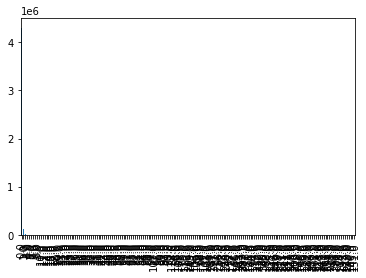

In [ ]:
pd.value_counts(df_train['clicks']).plot.bar()

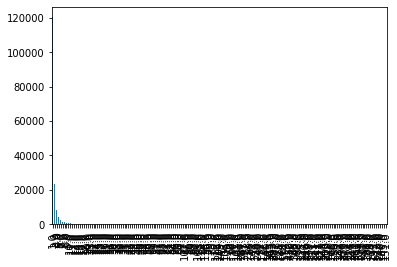

In [ ]:
pd.value_counts(df_train['clicks'][df_train['clicks']!=0]).plot.bar()

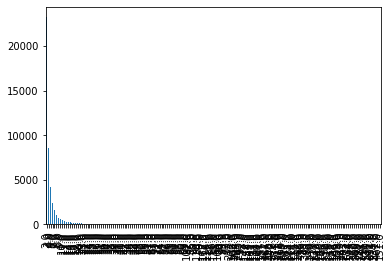

In [ ]:
pd.value_counts(df_train['clicks'][df_train['clicks']>1]).plot.bar()

In [ ]:
print("Imbalance ratio: {}".format(float(len(df_train[df_train['clicks']==0]))/len(df_train[df_train['clicks']!=0])))

Imbalance ratio: 25.84097899824835


In [ ]:
df_train.nunique()

date                 9
zone_id           2895
media_id           186
advertiser_id      116
campaign_id        495
domain           76574
visibility           2
ad_id            15032
width               19
height              14
country_ref         12
device              17
imps              1340
clicks             174
dtype: int64

In [ ]:
df_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,4459065,9,2017-05-01 00:00:00,737445,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zone_id,4459064.0,NaN,NaN,NaN,1059.060521,613.022056,1.0,700.0,869.0,1183.0,2928.0
media_id,4459064.0,NaN,NaN,NaN,86.253633,28.829773,1.0,74.0,87.0,94.0,187.0
advertiser_id,4459064.0,NaN,NaN,NaN,1642.385859,499.539594,0.0,1604.0,1611.0,1627.0,3210.0
campaign_id,4459064.0,NaN,NaN,NaN,8213.768762,2497.676896,2.0,8024.0,8059.0,8135.0,16054.0
domain,4380137,76574,orange.fr,175323,NaN,NaN,NaN,NaN,NaN,NaN,NaN
visibility,2295587.0,NaN,NaN,NaN,1.559412,0.496458,1.0,1.0,2.0,2.0,2.0
ad_id,4459064.0,NaN,NaN,NaN,6769.986163,3529.310694,1.0,4768.0,6826.0,9719.0,15318.0
width,4459064.0,NaN,NaN,NaN,438.832525,288.282661,19.0,300.0,300.0,728.0,1800.0
height,4459064.0,NaN,NaN,NaN,271.299267,211.540037,11.0,90.0,250.0,250.0,1000.0


In [ ]:
print(df_train.info())
print(df_train.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459065 entries, 0 to 4459064
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date           object 
 1   zone_id        float64
 2   media_id       float64
 3   advertiser_id  float64
 4   campaign_id    float64
 5   domain         object 
 6   visibility     float64
 7   ad_id          float64
 8   width          float64
 9   height         float64
 10  country_ref    object 
 11  device         object 
 12  imps           float64
 13  clicks         float64
dtypes: float64(10), object(4)
memory usage: 476.3+ MB
None
Index(['date', 'zone_id', 'media_id', 'advertiser_id', 'campaign_id', 'domain',
       'visibility', 'ad_id', 'width', 'height', 'country_ref', 'device',
       'imps', 'clicks'],
      dtype='object')


In [ ]:
print(df_train.shape)
print(df_test_final.shape)
print(100*df_train.isna().sum()/df_train.shape[0])

(4459065, 14)
(2019086, 13)
date              0.000000
zone_id           0.000022
media_id          0.000022
advertiser_id     0.000022
campaign_id       0.000022
domain            1.770057
visibility       48.518647
ad_id             0.000022
width             0.000022
height            0.000022
country_ref       0.000022
device            0.000022
imps              0.000022
clicks            0.000022
dtype: float64


In [ ]:
print(len(df_train['domain'].unique()))
print(len(df_train['device'].unique()))

76575
18


# **Feature engineering**

In [ ]:
df_train['CTR'] = df_train['clicks']/df_train['imps']

In [ ]:
def encode_categorical(column_name):
  # Create encoder
  ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)

  # Fit on training data
  ordinal_encoder.fit(df_train[column_name].values.reshape(-1, 1))

  # Transform the training and test data
  df_train[column_name] = ordinal_encoder.transform(df_train[column_name].values.reshape(-1, 1)).astype(int)
  df_test_final[column_name] = ordinal_encoder.transform(df_test_final[column_name].values.reshape(-1, 1)).astype(int)
  return df_train[column_name], df_test_final[column_name]

In [ ]:
df_train['domain'], df_test_final['domain'] = encode_categorical('domain')
df_train['device'], df_test_final['device'] = encode_categorical('device')
df_train['country_ref'], df_test_final['country_ref'] = encode_categorical('country_ref')
df_train['date'], df_test_final['date'] = encode_categorical('date')

In [ ]:
# df_train = df_train.interpolate()
# df_train['visibility'] = df_train['visibility'].apply(round)
df_train['visibility'] = df_train['visibility'].fillna(-1)
df_test_final['visibility'] = df_test_final['visibility'].fillna(-1)
print(100*df_train.isna().sum()/df_train.shape[0])
df_train.head()

date             0.000000
zone_id          0.000022
media_id         0.000022
advertiser_id    0.000022
campaign_id      0.000022
domain           0.000000
visibility       0.000000
ad_id            0.000022
width            0.000022
height           0.000022
country_ref      0.000000
device           0.000000
imps             0.000022
clicks           0.000022
CTR              0.000022
dtype: float64


,date,zone_id,media_id,advertiser_id,campaign_id,domain,visibility,ad_id,width,height,country_ref,device,imps,clicks,CTR
0,2,2794.0,149.0,3206.0,16034.0,23125,1.0,14885.0,250.0,250.0,11,12,1.0,0.0,0.0
1,6,879.0,77.0,1612.0,8060.0,60228,-1.0,7126.0,300.0,250.0,7,5,2.0,0.0,0.0
2,7,1321.0,119.0,2061.0,10306.0,2578,2.0,11696.0,320.0,50.0,9,8,1.0,0.0,0.0
3,4,2347.0,77.0,1605.0,8029.0,72351,-1.0,5837.0,1000.0,90.0,7,5,1.0,0.0,0.0
4,2,931.0,90.0,1604.0,8023.0,51376,-1.0,7414.0,300.0,250.0,7,5,1.0,0.0,0.0


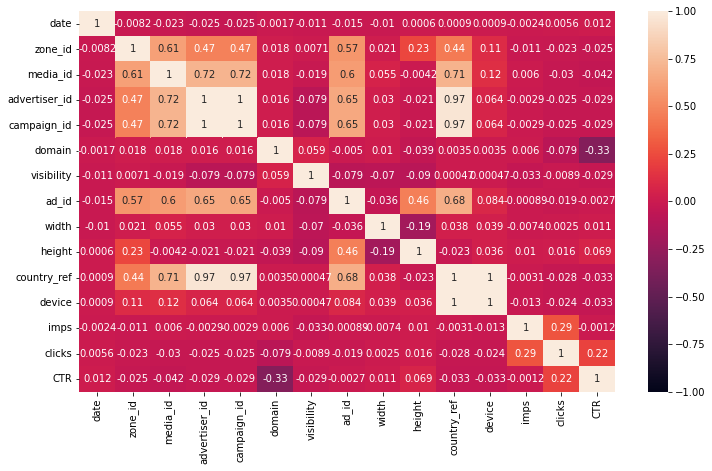

In [ ]:
plt.figure(figsize=(12, 7))
sns.heatmap(df_train.corr(), annot = True, vmin = -1, vmax = 1)
plt.show()

In [ ]:
# df_train_oversample = df_train[df_train['clicks']<min(pd.value_counts(df_train['clicks'])[-163:].index)]
# pd.value_counts(df_train_oversample['clicks'])
# columns = ['date', 'zone_id', 'media_id', 'advertiser_id', 'campaign_id', 'domain',
#        'visibility', 'ad_id', 'width', 'height', 'country_ref', 'device',
#        'imps']
# X_train_resample, X_val_resample, y_train_resample, y_val_resample = train_test_split(df_train_oversample[columns], df_train_oversample['clicks'], test_size=0.33, random_state=42)
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)
# ros.fit_resample(X_train_resample,y_train_resample)
# from collections import Counter
# print(sorted(Counter(y_train_resample).items()))

In [ ]:
columns = ['date','country_ref','zone_id', 'media_id', 'advertiser_id', 'campaign_id', 'domain',
       'visibility', 'ad_id', 'width', 'height','device',
       'imps']
scaler = StandardScaler()

X_train, X_val, y_train, y_val = train_test_split(df_train[columns], df_train['clicks'], test_size=0.20, random_state=42)
X_test = df_test_final[columns]

# X_val, X_val_tune, y_val, y_val_tune = train_test_split(df_train[columns], df_train['clicks'], test_size=0.50, random_state=42)

y_train_scaled = y_train/max(y_train)
y_val_scaled = y_val/max(y_train)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
# X_val_tune_scaled = scaler.transform(X_val_tune)
X_test_scaled = scaler.fit_transform(df_test_final[columns])

y_train_log = y_train.apply(lambda x: log(x+1))
y_val_log = y_val.apply(lambda x: log(x+1))
# y_val_tune_log = y_val_tune.apply(lambda x: log(x+1))

In [ ]:
# columns = ['date','country_ref','zone_id', 'media_id', 'advertiser_id', 'campaign_id', 'domain',
#        'visibility', 'ad_id', 'width', 'height','device',
#        'imps']
# scaler = StandardScaler()

# X_train, X_val, y_train, y_val = train_test_split(df_train[columns], df_train['clicks'], test_size=0.15, random_state=42)
# X_test = df_test_final[columns]

# y_train_log = y_train.apply(lambda x: log(x+1))
# y_val_log = y_val.apply(lambda x: log(x+1))

In [ ]:
# Calculate the skewness
print('Skewness with no preprocessing',skew(y_train, axis=0, bias=True))
# Calculate the kurtosis
print('Kurtosis with no preprocessing',kurtosis(y_train, axis=0, bias=True))
# Calculate the skewness
print('Skewness with logarithmic scaling',skew(y_train_log, axis=0, bias=True))
# Calculate the kurtosis
print('Kurtosis with with logarithmic scaling',kurtosis(y_train_log, axis=0, bias=True))
# more weight in the left tail of the distribution. kurtosis > 3, leptokurtic produce more outliers than the normal distribution

Skewness with no preprocessing nan
Kurtosis with no preprocessing nan
Skewness with logarithmic scaling nan
Kurtosis with with logarithmic scaling nan


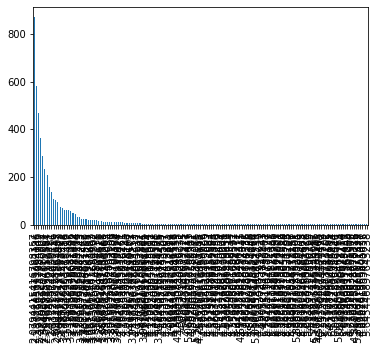

In [ ]:
pd.value_counts(y_train_log[y_train_log>2]).plot.bar()

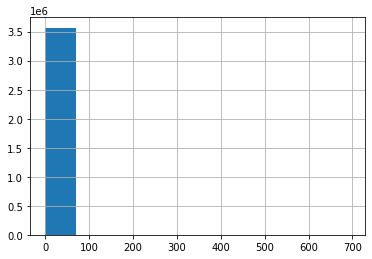

In [ ]:
y_train.hist()

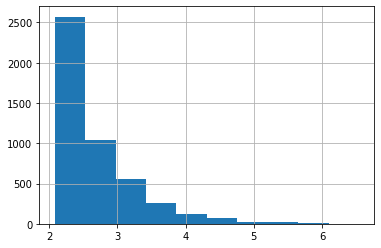

In [ ]:
y_train_log[y_train_log>2].hist()

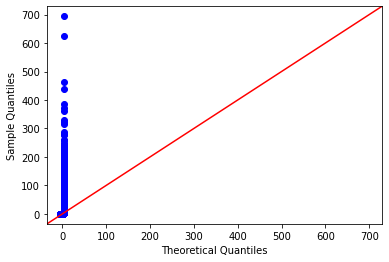

In [ ]:
sm.qqplot(y_train, line ='45')
py.show()

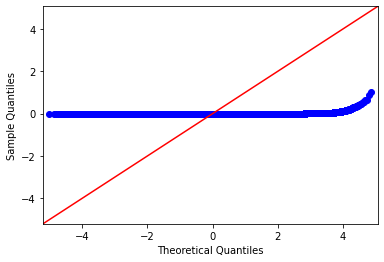

In [ ]:
sm.qqplot(y_train_scaled, line ='45')
py.show()

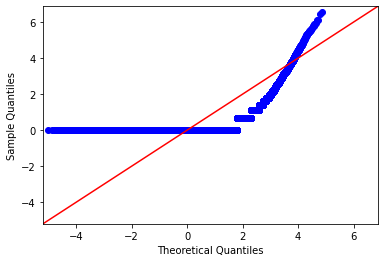

In [ ]:
sm.qqplot(y_train_log.values, line ='45')
py.show()

In [ ]:
# def compute_loss(model_chosen):
#   global count_pass_try
#   count_pass_try = 0
#   loss_val = 0
#   val_pred = model_chosen.predict(X_val)
#   # val_pred = val_pred*max(y_train)
#   for i in range(len(y_val)):
#     Y_hat = val_pred[i]/X_val['imps'].iloc[i]
#     # if Y_hat >=1:
#     #   Y_hat = val_pred[i]/(1+X_val['imps'].iloc[i])
#     Y_hat_bar = 1-Y_hat
#     try:
#       loss_val += X_val['imps'].iloc[i]*log(Y_hat_bar) + y_val.iloc[i]*log(Y_hat/Y_hat_bar)
#     except:
#       try:
#         Y_hat = abs(Y_hat)
#         Y_hat_bar = 1-Y_hat
#         loss_val += X_val['imps'].iloc[i]*log(Y_hat_bar) + y_val.iloc[i]*log(Y_hat/Y_hat_bar)
#       except:
#         count_pass_try+=1
#         pass
#   return -loss_val/sum(X_val['imps'])

# Linear_model = LinearRegression()
# Linear_model.fit(X_train,y_train)
# print('Error=',compute_loss(Linear_model))
# # print(count_pass_try)

# val_pred_linear = Linear_model.predict(X_val)
# rmse = (mean_squared_error(y_val, val_pred_linear))**(0.5)
# r2 = r2_score(y_val, val_pred_linear)
# print("Linear regression: difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

# Ridge_model = Ridge(alpha=10)
# Ridge_model.fit(X_train,y_train)

# print('Error=',compute_loss(Ridge_model))
# # print(count_pass_try)

# val_pred_ridge = Ridge_model.predict(X_val)
# rmse = (mean_squared_error(y_val, val_pred_ridge))**(0.5)
# r2 = r2_score(y_val, val_pred_ridge)
# print("Ridge: difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

# Lasso_model = Lasso(alpha=10)
# Lasso_model.fit(X_train,y_train)

# print('Error=',compute_loss(Lasso_model))
# # print(count_pass_try)

# val_pred_lasso = Lasso_model.predict(X_val)
# rmse = (mean_squared_error(y_val, val_pred_lasso))**(0.5)
# r2 = r2_score(y_val, val_pred_lasso)
# print("Lasso: difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

In [ ]:
# def compute_loss_scaled(model_chosen):
#   global count_pass_try
#   count_pass_try = 0
#   loss_val = 0
#   val_pred = model_chosen.predict(X_val_scaled)
#   val_pred = val_pred*max(y_train)
#   for i in range(len(y_val)):
#     Y_hat = val_pred[i]/X_val['imps'].iloc[i]
#     # if Y_hat >=1:
#     #   Y_hat = val_pred[i]/(1+X_val['imps'].iloc[i])
#     Y_hat_bar = 1-Y_hat
#     try:
#       loss_val += X_val['imps'].iloc[i]*log(Y_hat_bar) + y_val.iloc[i]*log(Y_hat/Y_hat_bar)
#     except:
#       try:
#         Y_hat = abs(Y_hat)
#         Y_hat_bar = 1-Y_hat
#         loss_val += X_val['imps'].iloc[i]*log(Y_hat_bar) + y_val.iloc[i]*log(Y_hat/Y_hat_bar)
#       except:
#         count_pass_try+=1
#         pass
#   return -loss_val/sum(X_val['imps'])

# Linear_model_scaled = LinearRegression()
# Linear_model_scaled.fit(X_train_scaled,y_train_scaled)
# print('Error=',compute_loss_scaled(Linear_model_scaled))
# # print(count_pass_try)

# val_pred_linear = Linear_model_scaled.predict(X_val_scaled)*max(y_train)
# rmse = (mean_squared_error(y_val, val_pred_linear))**(0.5)
# r2 = r2_score(y_val, val_pred_linear)
# print("Linear regression scaled: difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

# Ridge_model_scaled = Ridge(alpha=10)
# Ridge_model_scaled.fit(X_train_scaled,y_train_scaled)

# print('Error=',compute_loss_scaled(Ridge_model_scaled))
# # print(count_pass_try)

# val_pred_ridge = Ridge_model_scaled.predict(X_val_scaled)*max(y_train)
# rmse = (mean_squared_error(y_val, val_pred_ridge))**(0.5)
# r2 = r2_score(y_val, val_pred_ridge)
# print("Ridge scaled: difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

# Lasso_model_scaled = Lasso(alpha=10)
# Lasso_model_scaled.fit(X_train_scaled,y_train_scaled)

# print('Error=',compute_loss_scaled(Lasso_model_scaled))
# # print(count_pass_try)

# val_pred_lasso = Lasso_model_scaled.predict(X_val_scaled)*max(y_train)
# rmse = (mean_squared_error(y_val, val_pred_lasso))**(0.5)
# r2 = r2_score(y_val, val_pred_lasso)
# print("Lasso scaled: difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

In [ ]:
# def compute_loss_log_scaled(model_chosen):
#   global count_pass_try
#   count_pass_try = 0
#   loss_val = 0
#   val_pred = model_chosen.predict(X_val_scaled)
#   val_pred = list(map(lambda x:exp(x)-1,val_pred))
#   for i in range(len(y_val)):
#     Y_hat = val_pred[i]/X_val['imps'].iloc[i]
#     # if Y_hat >=1:
#     #   Y_hat = val_pred[i]/(1+X_val['imps'].iloc[i])
#     Y_hat_bar = 1-Y_hat
#     try:
#       loss_val += X_val['imps'].iloc[i]*log(Y_hat_bar) + y_val.iloc[i]*log(Y_hat/Y_hat_bar)
#     except:
#       try:
#         Y_hat = abs(Y_hat)
#         Y_hat_bar = 1-Y_hat
#         loss_val += X_val['imps'].iloc[i]*log(Y_hat_bar) + y_val.iloc[i]*log(Y_hat/Y_hat_bar)
#       except:
#         count_pass_try+=1
#         pass
#   return -loss_val/sum(X_val['imps'])

# Linear_model_log = LinearRegression()
# Linear_model_log.fit(X_train_scaled,y_train_log)

# print(compute_loss_log_scaled(Linear_model_log))

# val_pred_linear = list(map(lambda x:exp(x)-1,Linear_model_log.predict(X_val_scaled)))
# rmse = (mean_squared_error(y_val, val_pred_linear))**(0.5)
# r2 = r2_score(y_val, val_pred_linear)
# print("Linear regression log-scaled: difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))


# Lasso_model_log = Lasso(alpha=10)
# Lasso_model_log.fit(X_train_scaled,y_train_log)

# print(compute_loss_log_scaled(Lasso_model_log))

# val_pred_lasso = list(map(lambda x:exp(x)-1,Lasso_model_log.predict(X_val_scaled)))
# rmse = (mean_squared_error(y_val, val_pred_lasso))**(0.5)
# r2 = r2_score(y_val, val_pred_lasso)
# print("Lasso regression log-scaled: difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

# Ridge_model_log = Ridge(alpha=10)
# Ridge_model_log.fit(X_train_scaled,y_train_log)
# # print(Ridge_model_log.coef_)

# print(compute_loss_log_scaled(Ridge_model_log))
# print(count_pass_try)

# val_pred_ridge = list(map(lambda x:exp(x)-1,Ridge_model_log.predict(X_val_scaled)))
# rmse = (mean_squared_error(y_val, val_pred_ridge))**(0.5)
# r2 = r2_score(y_val, val_pred_ridge)
# print("Ridge regression log-scaled: difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

In [ ]:
# from sklearn.linear_model import SGDRegressor, HuberRegressor, TheilSenRegressor
# from sklearn.preprocessing import QuantileTransformer

# pt = QuantileTransformer(output_distribution='normal', random_state=0)
# testtttttt = pt.fit_transform(y_train_log.values.reshape(-1,1))
# sm.qqplot(testtttttt, line ='45')
# py.show()

# Elastic_model_log = ElasticNet(max_iter=1000,warm_start=False,tol=0.0001,alpha=1.0, l1_ratio=0.5)
# Elastic_model_log.fit(X_train_scaled,y_train_log)
# print(Elastic_model_log.coef_)

# print(compute_loss_log_scaled(Elastic_model_log))
# print(count_pass_try)

# val_pred_elastic = list(map(lambda x:exp(x)-1,Elastic_model_log.predict(X_val_scaled)))
# rmse = (mean_squared_error(y_val, val_pred_elastic))**(0.5)
# r2 = r2_score(y_val, val_pred_elastic)
# print("The difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

# SGD_model_log = SGDRegressor(max_iter=1000, tol=1e-3)
# SGD_model_log.fit(X_train_scaled,y_train_log)
# print(SGD_model_log.coef_)

# print(compute_loss_log_scaled(SGD_model_log))
# print(count_pass_try)

# val_pred_sgd = list(map(lambda x:exp(x)-1,SGD_model_log.predict(X_val_scaled)))
# rmse = (mean_squared_error(y_val, val_pred_sgd))**(0.5)
# r2 = r2_score(y_val, val_pred_sgd)
# print("The difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

# SGD_model_log = SGDRegressor(max_iter=1000, tol=1e-3)
# SGD_model_log.fit(X_train_scaled,y_train_log)
# print(SGD_model_log.coef_)

# print(compute_loss_log_scaled(SGD_model_log))
# print(count_pass_try)

# val_pred_sgd = list(map(lambda x:exp(x)-1,SGD_model_log.predict(X_val_scaled)))
# rmse = (mean_squared_error(y_val, val_pred_sgd))**(0.5)
# r2 = r2_score(y_val, val_pred_sgd)
# print("The difference between actual and predicted values", rmse)
# print('R2: {:.2f}'.format(r2))

In [ ]:
# from sklearn.utils.class_weight import compute_sample_weight
# sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_log)
# sample_weights

# class DerivativeCustomLoss(object):
#     def calc_ders_range(self, approxes, targets):
#         # This function should return a list of pairs (der1, der2), where
#         # der1 is the first derivative of the loss function with respect
#         # to the predicted value, and der2 is the second derivative.
#         result = []
#         for index in range(len(targets)):
#             der1 = -((targets[index]/approxes[index])-((1-targets[index])/(X_train.iloc[index]-approxes[index])))
#             der2 = (targets[index]/(approxes[index])^2) + ((1-targets[index])/(X_train.iloc[index]-targets[index])^2)                                   

#             result.append((der1, der2))

#         return result

# def custom_loss(y_pred,y_true):
#   loss_val = 0
#   for i in range(len(y_true)):
#     Y_hat = y_pred[i]/X_train['imps'].iloc[i]
#     Y_hat_bar = 1-Y_hat
#     print(Y_hat)
#     try:
#       loss_val += X_train['imps'].iloc[i]*log(Y_hat_bar) + y_true.iloc[i]*log(Y_hat/Y_hat_bar)
#     except:
#       try:
#         Y_hat = abs(Y_hat)
#         Y_hat_bar = 1-Y_hat
#         loss_val += X_train['imps'].iloc[i]*log(Y_hat_bar) + y_true.iloc[i]*log(Y_hat/Y_hat_bar)
#       except:
#         pass
#   return -loss_val/sum(X_train['imps'])

# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.5,
#                 max_depth = 2, alpha = 10, n_estimators = 10)

# xg_reg.fit(X_train,y_train)
# 0.07662433715197157

# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.5,
#                 max_depth = 2, alpha = 10, n_estimators = 10)

# xg_reg.fit(X_train,y_train)

# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.4,
#                 max_depth = 2, alpha = 10, n_estimators = 10)

# xg_reg.fit(X_train,y_train)

# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.7, learning_rate = 0.4,
#                 max_depth = 10, alpha = 10, n_estimators = 100)

# xg_reg.fit(X_train,y_train)
# 0.05869134292135717 alpha=10, colsample_bytree=0.7, learning_rate=0.4, max_depth=10 n_estimators=100

# print(compute_loss(xg_reg))
# print(count_pass_try)

# xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()
# plt.savefig('xgb.jpg', dpi=600, quality=80, optimize=True, progressive=True)

# xgb.plot_importance(xg_reg)
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.show()
# plt.savefig('Feature Importance', dpi=600, quality=80, optimize=True, progressive=True)

# xg_reg = xgb.XGBRegressor()

# xg_reg.fit(X_train,y_train)

# print(compute_loss(xg_reg))
# print(count_pass_try)

# params = {
#     'task': 'train', 
#     'boosting': 'dart',
#     'num_iteration': 2000,
#     'boosting': 'gbdt',
#     'objective': 'regression',
#     'num_leaves': 20,
#     'max_depth': 10,
#     'learning_rate': 0.5,
#     'metric': {'l2','l1'},
#     'verbose': -1
# }

# # loading data
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# lgb_reg = lgb.train(params,train_set=lgb_train,valid_sets=lgb_eval,early_stopping_rounds=300)

# print(compute_loss(lgb_reg))
# print(count_pass_try) # 0.05885859414947101
# params = {
#     'task': 'train', 
#     'boosting': 'dart',
#     'num_iteration': 2000,
#     'boosting': 'gbdt',
#     'objective': 'regression',
#     'num_leaves': 20,
#     'max_depth': 10,
#     'learning_rate': 0.5,
#     'metric': {'l2','l1'},
#     'verbose': -1
# }
# plotting feature importance
# lgb.plot_importance(lgb_reg, height=1)

In [ ]:
X_val['imps']

55330      2.0
631914     1.0
3727353    1.0
1369578    1.0
3258258    1.0
          ... 
2092157    1.0
1952673    1.0
429041     1.0
4094452    1.0
1328302    1.0
Name: imps, Length: 891813, dtype: float64

In [ ]:
def compute_loss_log(model_chosen):
  global count_pass_try
  count_pass_try = 0
  loss_val = 0
  val_pred = model_chosen.predict(X_val)
  val_pred = list(map(lambda x:exp(x)-1,val_pred))
  for i in range(len(y_val)):
    Y_hat = val_pred[i]/X_val['imps'].iloc[i]
    Y_hat_bar = 1-Y_hat
    try:
      loss_val += X_val['imps'].iloc[i]*log(Y_hat_bar) + y_val.iloc[i]*log(Y_hat/Y_hat_bar)
    except:
      try:
        Y_hat = abs(Y_hat)
        Y_hat_bar = 1-Y_hat
        loss_val += X_val['imps'].iloc[i]*log(Y_hat_bar) + y_val.iloc[i]*log(Y_hat/Y_hat_bar)
      except:
        count_pass_try+=1
        pass
  return -loss_val/sum(X_val['imps'])

In [ ]:
# Initialize CatBoostRegressor
# iterations=10,learning_rate=1,depth=2, l2_leaf_reg=0 ,random_strength
# cat_reg = CatBoostRegressor(iterations=10,depth=12,subsample=1,grow_policy='Lossguide')

cat_reg = CatBoostRegressor(iterations=1000,
                            depth=32,
                            subsample=1,
                            grow_policy='Lossguide',
                            max_leaves= 16384,
                            score_function='L2',
                            model_size_reg=0,
                            use_best_model = True)
# Fit model
cat_reg.fit(X_train, y_train_log,eval_set=(X_val, y_val_log),early_stopping_rounds=50)
# cat_reg.fit(X_train, y_train_log,eval_set=(X_val_tune, y_val_tune_log),early_stopping_rounds=50)
# print(compute_loss_log(cat_reg))
# print(count_pass_try) # 0.05106602955118768 using best model, max_leaves= 16384

CatBoostError: ignored

In [ ]:
# model = CatBoostRegressor()      # parameters not required.
# model.load_model('CatBoostModel (1)')
val_pred_cat = list(map(lambda x:exp(x)-1,cat_reg.predict(X_test)))
response_catboost = np.round_(val_pred_cat)
# response_catboost = val_pred_cat
response_catboost[response_catboost==-0]=0
Predictions_CTR = response_catboost/X_test['imps']
Predictions_CTR[Predictions_CTR>1] = 1
Predictions_CTR[Predictions_CTR<0] = 0
# np.savetxt("Predictions_CTR.txt", Predictions_CTR)

In [ ]:
# Save model 
# cat_reg.save_model('CatBoostModel')    # extension not required.

# Load model
# model = CatBoostRegressor()      # parameters not required.
# model.load_model('CatBoostModel')
# print(compute_loss_log(model))
# print(count_pass_try)

In [ ]:
100*pd.value_counts(response_catboost)/len(response_catboost)

In [ ]:
# Get predictions
# val_pred_linear_reg = max(y_train)*Linear_model_scaled.predict(X_val_scaled)
# val_pred_xgboost = xg_reg.predict(X_val)
# val_pred_lightgbm = lgb_reg.predict(X_val)
val_pred_cat_2 = list(map(lambda x:exp(x)-1,cat_reg.predict(X_val)))
rmse = (mean_squared_error(y_val, val_pred_cat_2))**(0.5)
r2 = r2_score(y_val, val_pred_cat_2)
print(compute_loss_log(cat_reg))
print("The difference between actual and predicted values", rmse)
print('R2: {:.2f}'.format(r2))

In [ ]:
%%time 
exp(cat_reg.predict(X_val.iloc[0]))-1

In [ ]:
cat_reg.get_all_params()

In [ ]:
dataframe_features_cat = pd.DataFrame({
    'feature_importance': cat_reg.get_feature_importance(), 
    'feature_names': X_val.columns}).sort_values(by=['feature_importance'],
                                                 ascending=False)
dataframe_features_cat.sort_values(
    by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

In [ ]:
# # Save model 
# cat_reg.save_model('CatBoostModel')    # extension not required.

# # Load model
# model = CatBoostRegressor()      # parameters not required.
# model.load_model('CatBoostModel')

# **Compute the error**

In [ ]:
# min(val_pred_linear_reg), max(val_pred_linear_reg)

In [ ]:
# min(val_pred_lightgbm), max(val_pred_lightgbm)

In [ ]:
# min(val_pred_xgboost),max(val_pred_xgboost)

In [ ]:
min(val_pred_cat), max(val_pred_cat)

In [ ]:
# response_linear_reg = np.round_(val_pred_linear_reg)
# response_linear_reg[response_linear_reg==-0]=0
# response_linear_reg

In [ ]:
# response_lightgbm = np.round_(val_pred_lightgbm)
# response_lightgbm[response_lightgbm==-0]=0
# response_lightgbm

In [ ]:
# response_xgboost = np.round_(val_pred_xgboost)
# response_xgboost[response_xgboost==-0]=0
# response_xgboost

In [ ]:
response_catboost = np.round_(val_pred_cat_2)
response_catboost[response_catboost==-0]=0
response_catboost

In [ ]:
# 100*pd.value_counts(response_linear_reg)/len(response_linear_reg)

In [ ]:
# 100*pd.value_counts(response_lightgbm)/len(response_lightgbm)

In [ ]:
# 100*pd.value_counts(response_xgboost)/len(response_xgboost)

In [ ]:
100*pd.value_counts(y_val)/len(y_val)

In [ ]:
100*pd.value_counts(response_catboost)/len(response_catboost)

In [ ]:
# pd.value_counts(abs(response_linear_reg-y_val))[0.0]/len(y_val)

In [ ]:
# pd.value_counts(abs(response_lightgbm-y_val))[0.0]/len(y_val)

In [ ]:
# pd.value_counts(abs(response_xgboost-y_val))[0.0]/len(y_val)

In [ ]:
pd.value_counts(abs(response_catboost-y_val))[0.0]/len(y_val)

In [ ]:
# pd.value_counts(abs(response_linear_reg-y_val))

In [ ]:
# pd.value_counts(abs(response_lightgbm-y_val))

In [ ]:
# pd.value_counts(abs(response_xgboost-y_val))

In [ ]:
100*pd.value_counts(abs(response_catboost-y_val))/len(y_val)

In [ ]:
pd.value_counts(y_val)[0.0]/len(y_val)

In [ ]:
# pd.value_counts(response_linear_reg)[0.0]/len(y_val)

In [ ]:
# pd.value_counts(response_lightgbm)[0.0]/len(y_val)

In [ ]:
# pd.value_counts(response_xgboost)[0.0]/len(y_val)

In [ ]:
pd.value_counts(response_catboost)[0.0]/len(y_val)

In [ ]:
# max(y_val/X_val['imps'])

In [ ]:
# Predictions_CTR = response_catboost/X_val['imps']
# Predictions_CTR[Predictions_CTR>1] = 1
# Predictions_CTR[Predictions_CTR<0] = 0

In [ ]:
# min(Predictions_CTR), max(Predictions_CTR)

In [ ]:
# np.savetxt("Predictions_CTR.txt", Predictions_CTR)

In [ ]:
# # Displaying the contents of the text file
# content = np.loadtxt('Predictions_CTR.txt')
# print("\nContent in Predictions_CTR.txt:\n", content)